In [1]:
# A separate notebook for dealing with all data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import *
import seaborn as sns
sns.set(font_scale = 1.8)
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

# Functions

In [2]:
def get_label_file():
    """
    Returns the one-hot encoded label matrix corresponding to the wordpiece-segmented and BIO-encoded SUC3 dataset named entity tags
    """
    data_type = np.uint8
    g = np.memmap('../data/ONE_HOT_LABELS.dat', dtype=data_type, shape=(74165, 100, 33))
    
    return g

In [3]:
def get_embed_file():
    """
    Returns the ALBERT wordpiece embeddings for the entire SUC3 dataset
    """
    data_type = np.float64
    f = np.memmap('../data/MMAP_MATRIX.dat', dtype=data_type, shape=(74165, 100, 768))
    return f

In [20]:
from keras.layers import LSTM, Bidirectional, TimeDistributed, Dropout, Dense
from keras.models import Model, Input
def bilstm_model(units = 200):
    """
    The model selection was very basic. Testing was performed on the same 5000 sentences with number of units = 100, 200, 300, 400
    Each subsequent increase in units massivly increased complexity for minor gains in performance.
    10% of the data was used for validation
    
    """
    #Define the input shape. Each datapoint is a sentence consisting of seqlength words, each word 784dims
    input = Input(shape=(train_x.shape[1], train_x.shape[2]))
    # Pass it through a bidirectional lstm
    model = Bidirectional(LSTM(units=units, return_sequences=True, recurrent_dropout=0.1))(input)

    # add a timedistributed layer
    out = TimeDistributed(Dense(train_y.shape[2], activation="softmax"))(model)  # softmax output layer
    
    model = Model(input, out)
    
    # Compile it
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    #print(model.summary())
    return model


In [5]:
import keras
class DataGenerator(keras.utils.Sequence):
    """
    A datagenerator. Really just a generator (something that iteratively computes/generates elements in a list, rather than keeping the entire list in RAM) 
    that extends a keras class. This allows us to train on data larger than RAM
    
    This datagenerator is INDEX based. It takes INDICES, and returns the arrays on disk that correspond to these indices
    """
    def __init__(self, list_IDs, batch_size=32, shuffle=False):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """
        Denotes the number of batches per epoch
        A common way to decide this is simply total amount of samples over batch size
        the batch size you can handle is, of course, determined by your computer, so set that accordingly
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """
        This function is responsible for grabbing the indices to load for each batch.
        And then calling the data generator for those ids
        """
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """
        If desired, shuffles the indices after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """
        This function brings data from disk into RAM.
        It is called once per batch, and thus brings in one batch of data.
        """
        X = get_embed_file()[list_IDs_temp,:,:]
        y = get_label_file()[list_IDs_temp,:,:]
        
        # We take the data at the specified indices and retrieve it
        return X, y


In [6]:
def cross_validate(classifier_function, nr_folds, indices):
    """
    Input:
        Classifier_function; a function that generates a classifier with the desired attributes. Will be used to reset the classifier between folds
        nr_folds, how many folds to split into
        indices, a list of the indices we will pass to our data generators
        
    Output:
        For each fold, three saved files.
        One containing the model
        One containing the model weights
        One containing the history dataframe
    """
    fold_size = int(np.floor(len(indices)/nr_folds))
    
    for i in range(nr_folds):
        print(f"Working on fold {i + 1} of {nr_folds}")
        
        #Select the indices to validate on
        validation_indices = indices[i * fold_size : (i+1) * fold_size]
        
        #Select all indices except those we validate on for training
        train_indices =  [x for x in indices if x not in validation_indices]
        
        print(f"Training on {len(train_indices)}, validating on {len(validation_indices)}")
        
        print("Resetting model...")
        classifier = classifier_function()

        print("Created datagenerators")
        dataGen = DataGenerator(train_indices)
        valiGen = DataGenerator(validation_indices)
        
        print("Commencing training")
        history = classifier.fit_generator(generator=dataGen,
                                           validation_data=valiGen,
                                           epochs = 10)
        
        print("TRAINING COMPLETE")
        
        #Pickle the training data in case it will be neeeded
        training_df = pd.DataFrame()
        for metric in history.history.keys():
            training_df[metric] = history.history[metric]
            
        training_df.to_pickle(f'../data/fold_{i}_history')
        print(f"SAVING HISTORY '../data/fold_{i}_history'")
        
        # Serialize the model in case we'll need it
        #model_json = classifier.to_json()
        #with open(f"../data/fold_{i}_model.json", "w+") as json_file:
        #    json_file.write(model_json)
        #print(f"SAVING MODEL ../data/fold_{i}_model.json")

            
        # Serialize weights to HDF5, becuse we WILL need them
        classifier.save_weights(f'../data/fold_{i}_weights.h5')

        print(f"SAVING MODEL WEIGHTS AS ../data/fold_{i}_weights.h5")
    
    print("PROCESS COMPLETED")


In [7]:
def remap(matrix, label_dictionary):
    """
    Utility function to take one-hot encoded labels and return the label with the higest probability
    """
    
    #Switch index to label
    def switcher(x):
        return label_dictionary[x]
    
    #Get the index along the second axis (the one-hot encoding) with the highest value
    predicted_index = pd.DataFrame(np.argmax(matrix, axis=2))
    
    #Use our dictionary to map this index to the class
    label_representation = predicted_index.applymap(switcher)

    return label_representation

In [24]:
def bilstm_mode2l(units = 200):
    """
    The model selection was very basic. Testing was performed on the same 5000 sentences with number of units = 100, 200, 300, 400
    Each subsequent increase in units massivly increased complexity for minor gains in performance.
    10% of the data was used for validation
    
    """
    #Define the input shape. Each datapoint is a sentence consisting of seqlength words, each word 784dims
    input = Input(shape=(train_x.shape[1], train_x.shape[2]))
    # Pass it through a bidirectional lstm
    model = Bidirectional(LSTM(units=units, return_sequences=True, recurrent_dropout=0.1))(input)

    # add a timedistributed layer
    out = TimeDistributed(Dense(train_y.shape[2], activation="softmax"))(model)  # softmax output layer
    
    model = Model(input, out)
    
    # Compile it
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model


In [25]:
bilstm_mode2l()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100, 768)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 400)          1550400   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 100, 33)           13233     
Total params: 1,563,633
Trainable params: 1,563,633
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
bilstm_mode2l()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 768)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 400)               1550400   
Total params: 1,550,400
Trainable params: 1,550,400
Non-trainable params: 0
_________________________________________________________________
None


# SUBSET TESTING
For quick testing without using the data generator

In [12]:
# Get the memory mapped arrays
embedding_pointer = get_embed_file()
label_pointer = get_label_file()

#Select a subset
train_x = embedding_pointer[:5000]
train_y = label_pointer[:5000]
test_x = embedding_pointer[5000:6000]
test_y = label_pointer[5000:6000]

In [69]:
def train_the_model(classifier):
    # Train, setting some data aside for evaluation
    history = classifier.fit(
            train_x,
            train_y,
            epochs=10,
            batch_size=50,
            validation_split=0.1)
    #print('\nhistory dict:', history.history.keys())
    return history
#train_the_model()

In [10]:
def evaluate_the_model():
    # Evalue it on some other data

    print('\nEvaluate on test data')
    results = classifier.evaluate(x = test_x,
                                 y = test_y)
    for i, metric in enumerate(classifier.metrics_names):
        print(f"{metric}: {results[i]}")

# MODEL config subset testing
Just to see the complexity-performance ratio for different units

In [70]:
def subset_test_for_unit_count():
    to_test = [50, 100, 200, 300, 400, 500]

    df = pd.DataFrame()
    for units in to_test:
        model = bilstm_model(units = units)
        history = train_the_model(model)

        training_df = pd.DataFrame()
        for metric in history.history.keys():
            training_df[metric] = history.history[metric]

        training_df['units'] = units
        training_df['params'] = model.count_params()
        df = df.append(training_df)
    df.to_pickle(f'../data/subset_cell_test_hist')
    return df
#subset_test_for_unit_count()

In [201]:
subset_hist = pd.read_pickle('../data/subset_cell_test_hist')
last = subset_hist.loc[9]
complexity = last[['params', 'units']]
last = last.drop('params', axis = 1)
last.index = last.units
losses = last[['val_loss', 'loss']]
accs = last[['val_accuracy', 'accuracy']]


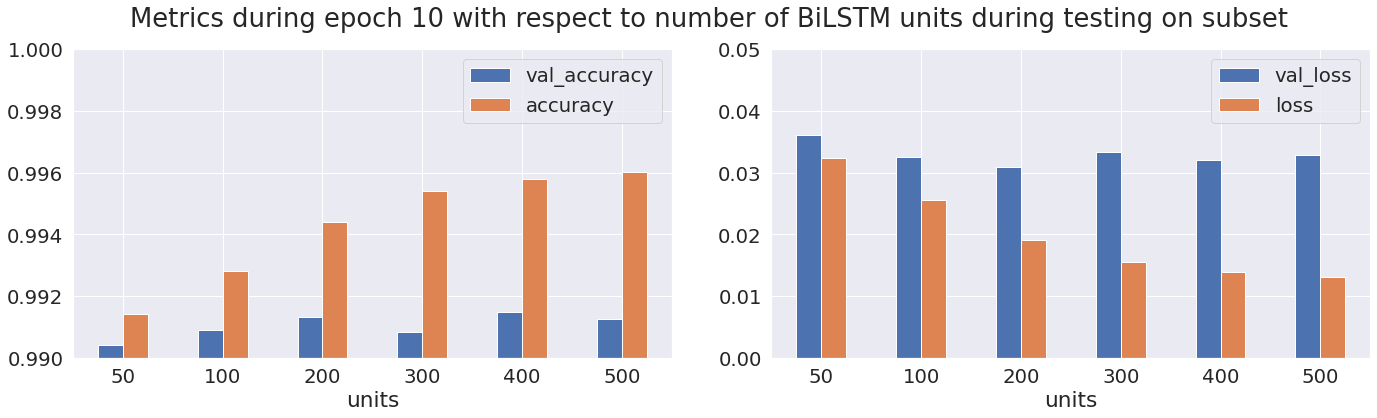

In [256]:
fig, axs = plt.subplots(ncols = 2, figsize = (20, 6))
fig.suptitle('Metrics during epoch 10 with respect to number of BiLSTM units during testing on subset')
fig.tight_layout(pad=2)

accs.plot(kind='bar', ax = axs[0])
axs[0].set_ylim(0.99, 1)
axs[0].set_xticklabels(labels = axs[0].get_xticklabels(), rotation=0 )

losses.plot(kind='bar', ax = axs[1])
axs[1].set_ylim(0, 0.05)

axs[1].set_xticklabels(labels = axs[1].get_xticklabels(), rotation=0 )
plt.savefig("../data/assets/subset_test.png")
plt.show()

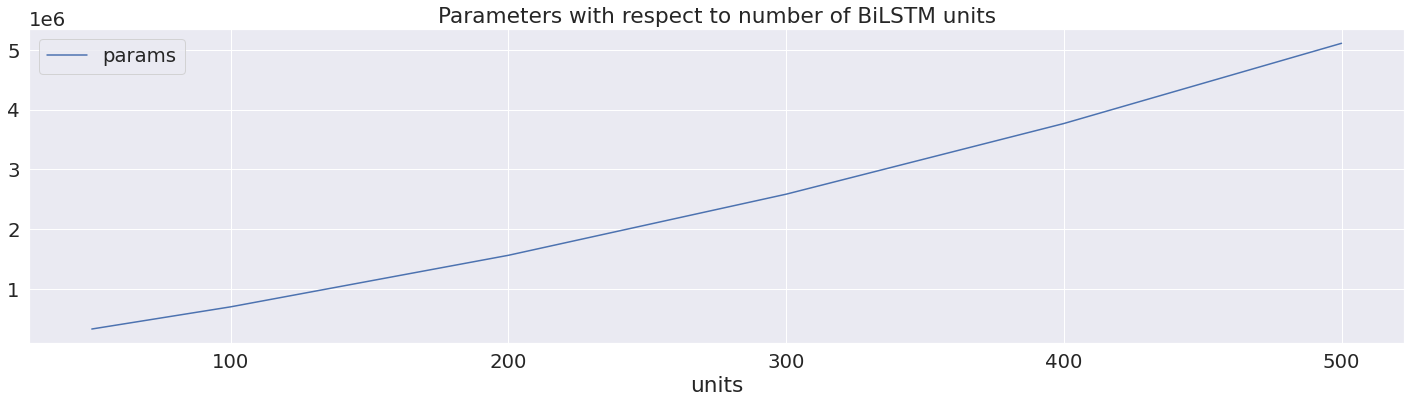

In [257]:
complexity.index = complexity.units
fig, ax = plt.subplots(figsize =(20, 6))
complexity[['params']].plot(ax =ax)
ax.set_title("Parameters with respect to number of BiLSTM units")
fig.tight_layout(pad=1)
plt.savefig("../data/assets/complexity.png")
plt.show()

In [216]:
complexity.index = complexity.units

In [38]:
best_df = pd.DataFrame()
for name, group in df.groupby('units'):
    best = group[group.val_loss == group.val_loss.min()]
    best_df = best_df.append(best)

In [51]:
y = best_df.loss
y2 = best_df.units
x =best_df.params

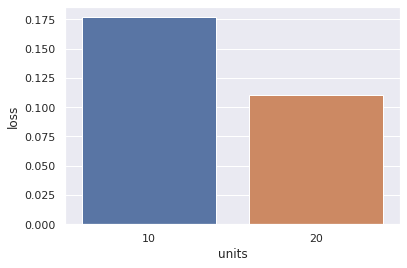

In [57]:
import seaborn as sns
sns.set()
sns.barplot(y2,y)

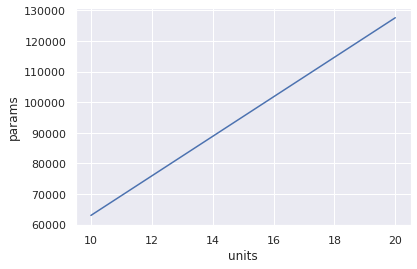

In [65]:
sns.lineplot(y2, x, )

# CROSS VALIDATION ON ENTIRE DATSET

The test indices will be the last 10 % and we won't touch those at all for the moment.

We will make use of 5-fold cross validation to reduce bias in our results. 


In [11]:
sentence_indices = [i for i in range(get_embed_file().shape[0])]

#Test consist of the last 10 %
TEST = sentence_indices[66749:]
CROSSVAL = sentence_indices[:66749]

In [12]:
#Let's keep track on time because that can be interesting to know.
import time
start = time.time()
#cross_validate(bilstm_model, 5, CROSSVAL)
end = time.time()
print(f"Time needed for CV on entire dataset = {(end-start)/3600} hours")

Time needed for CV on entire dataset = 4.834598965115017e-09 hours


In [13]:
#vTime needed for CV on entire dataset = 3.1499764224555755 hours

# CROSS_VALIDATED TRAINING HISTORY
Returns graphs displaying the average metrics across all folds

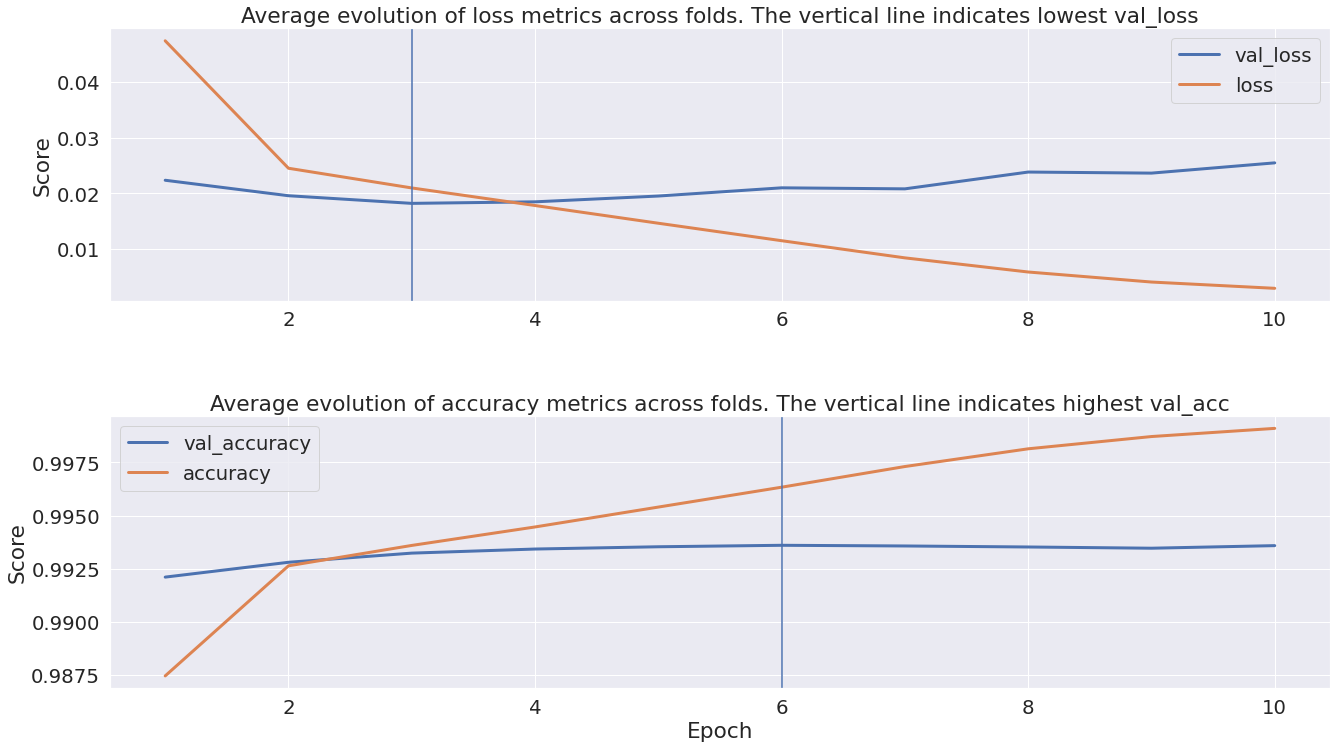

In [15]:
def show_cv_training_hist():
    """
    Loads the training histories from disk, averages them and plots the graph, also saving it to disk
    """
    h1 = pd.read_pickle('../data/cross_val/fold_0_history')
    h2 = pd.read_pickle('../data/cross_val/fold_1_history')
    h3 = pd.read_pickle('../data/cross_val/fold_2_history')
    h4 = pd.read_pickle('../data/cross_val/fold_3_history')
    h5 = pd.read_pickle('../data/cross_val/fold_4_history')
    
    h_final = (h1 + h2 + h3 + h4 + h5)/5
    
    #Cosmetic change so we start from epoch 1, not 0
    h_final.index = h_final.index + 1
    
    fig, axs = plt.subplots(nrows= 2, figsize = (20,12))
    axs[0].set_title("Average evolution of loss metrics across folds. The vertical line indicates lowest val_loss")
    h_final[['val_loss', 'loss']].plot(ax= axs[0], linewidth=3)
    axs[0].set_ylabel('Score')
    axs[0].axvline(x= np.argmin(h_final['val_loss']) + 1)
 

    axs[1].set_title("Average evolution of accuracy metrics across folds. The vertical line indicates highest val_acc")
    h_final[['val_accuracy', 'accuracy']].plot(ax= axs[1], linewidth=3)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Score')
    axs[1].axvline(x= np.argmax(h_final['val_accuracy'])+1)
    fig.tight_layout(pad=3.0)
    plt.savefig("../data/assets/avg_history.png")

    plt.show()
    return h_final
z = show_cv_training_hist()

In [16]:
z

,val_loss,val_accuracy,loss,accuracy
1,0.022331,0.992096,0.047402,0.987437
2,0.019549,0.992795,0.024488,0.992629
3,0.018176,0.993227,0.020949,0.993590
4,0.018452,0.993420,0.017790,0.994460
5,0.019494,0.993527,0.014604,0.995398
6,0.020970,0.993596,0.011465,0.996335
7,0.020785,0.993564,0.008379,0.997310
8,0.023805,0.993516,0.005838,0.998145
9,0.023613,0.993458,0.004034,0.998723
10,0.025457,0.993580,0.002904,0.999108


# Testing an individual fold
For sanity checking, let's retrieve the weights from one of the final folds and test it on some data

In [17]:
# Model and its weights
classifier = bilstm_model()

# load weights into new model
classifier.load_weights("../data/cross_val/fold_0_weights.h5")
print("Loaded model from disk")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 768)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 400)          1550400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 33)           13233     
Total params: 1,563,633
Trainable params: 1,563,633
Non-trainable params: 0
_________________________________________________________________
None
Loaded model from disk


In [18]:
#Load data from to test on. Not from TEST, we're still saving that
evalGen = DataGenerator(CROSSVAL[:5000])
print('\nEvaluate on test data')
results = classifier.evaluate_generator(evalGen)
for i, metric in enumerate(classifier.metrics_names):
    print(f"{metric}: {results[i]}")



Evaluate on test data
loss: 0.01637890189886093
accuracy: 0.9933633804321289


# Train model for test
Having determined that our cv score is the best around epoch 3-5, let's train a model on all the data except test, and then evaluate it on test

In [19]:
def create_final_model(classifier_function): 
    """
    Creates, trains, and saves the final model to disk
    """
    TEST = sentence_indices[66749:]
    TRAIN= sentence_indices[:66749]

    print("Creating model...")
    classifier = classifier_function()

    print("Created datagenerators")
    dataGen = DataGenerator(TRAIN)

    print("Commencing training")
    history = classifier.fit_generator(generator=dataGen,
                                       epochs = 5)
    print("TRAINING COMPLETE")

    #Pickle the training data in case it will be neeeded
    training_df = pd.DataFrame()
    for metric in history.history.keys():
        training_df[metric] = history.history[metric]

    training_df.to_pickle(f'../data/test_history')
    print(f"SAVING HISTORY '../data/test_history'")

    # Serialize weights to HDF5, becuse we WILL need them
    classifier.save_weights(f'../data/test_weights.h5')

    print(f"SAVING MODEL WEIGHTS AS ../data/test_weights.h5")

In [20]:
#train_model_for_test(bilstm_model)

# Test final model

## Average loss and accuracy

In [21]:
classifier = bilstm_model()

# load weights into new model
classifier.load_weights("../data/cross_val/test_weights.h5")

evalGen = DataGenerator(TEST)
print('\nEvaluate on test data')
results = classifier.evaluate_generator(evalGen)
for i, metric in enumerate(classifier.metrics_names):
    print(f"{metric}: {results[i]}")


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 768)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 400)          1550400   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 33)           13233     
Total params: 1,563,633
Trainable params: 1,563,633
Non-trainable params: 0
_________________________________________________________________
None

Evaluate on test data
loss: 0.02116389572620392
accuracy: 0.9935781955718994


## Classification reports

In [22]:
prediction_probabilities = classifier.predict_generator(evalGen)

In [23]:
label_dictionary = np.load("../data/dummy_index_label_dict.npy", allow_pickle=True).tolist()

In [24]:
predicted_classes = remap(prediction_probabilities, label_dictionary)
true_classes = remap(get_label_file()[TEST], label_dictionary)
true_classes = true_classes[:7392]

In [25]:
# Unravel it
predicted_classes = predicted_classes.values.reshape(-1,1)
true_classes = true_classes.values.reshape(-1,1)

In [26]:
#Grab list of all NE labels in test set
BI_labels = list(set(true_classes.reshape(-1,)))
BI_labels.remove('B-O') 
BI_labels.remove('I-O') 
BI_labels.remove('[CLS]') 
BI_labels.remove('[SEP]') 
BI_labels.remove('<pad>') 
BI_labels.remove('I-OBJ') 
BI_labels

#Grab list of all B-labels in test
B_labels = [label for label in BI_labels if label[0] =='B']
B_labels

#Grab list of all principal categories
B_main_labels = list({label[:5] for label in B_labels})
B_main_labels

['B-EVN', 'B-WRK', 'B-PRS', 'B-TME', 'B-MSR', 'B-LOC', 'B-ORG', 'B-OBJ']

## Classification report (B and I tokens)

In [27]:
from sklearn.metrics import classification_report

print("USING ALL ENTITY LABELS")
report1 = classification_report(y_true=true_classes, y_pred=predicted_classes, labels = BI_labels, output_dict=True, zero_division=0)
report1 = pd.DataFrame(report1).transpose()
report1

USING ALL ENTITY LABELS


,precision,recall,f1-score,support
B-WRK,0.700000,0.262500,0.381818,80.0
I-PRS/WRK,0.000000,0.000000,0.000000,1.0
I-EVN,0.263158,0.065789,0.105263,76.0
I-LOC/PRS,0.000000,0.000000,0.000000,7.0
I-WRK,0.590361,0.207627,0.307210,236.0
I-LOC/ORG,0.000000,0.000000,0.000000,6.0
I-MSR,0.845833,0.785300,0.814443,517.0
I-ORG,0.644764,0.688596,0.665960,456.0
I-PRS,0.898185,0.846556,0.871607,2105.0
I-LOC,0.768657,0.571165,0.655355,541.0


In [28]:
#report.sort_values(by ='f1-score', ascending = False)

In [29]:
#save to file
caption = 'Classification report using all entity labels in the test set'
label = 'l_report'
sentence_table = report1.to_latex(index=True, float_format="%.3f", caption=caption, label = label, bold_rows=True)
print(sentence_table)


\begin{table}
\centering
\caption{Classification report using all entity labels in the test set}
\label{l_report}
\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &   support \\
\midrule
\textbf{B-WRK       } &      0.700 &   0.263 &     0.382 &    80.000 \\
\textbf{I-PRS/WRK   } &      0.000 &   0.000 &     0.000 &     1.000 \\
\textbf{I-EVN       } &      0.263 &   0.066 &     0.105 &    76.000 \\
\textbf{I-LOC/PRS   } &      0.000 &   0.000 &     0.000 &     7.000 \\
\textbf{I-WRK       } &      0.590 &   0.208 &     0.307 &   236.000 \\
\textbf{I-LOC/ORG   } &      0.000 &   0.000 &     0.000 &     6.000 \\
\textbf{I-MSR       } &      0.846 &   0.785 &     0.814 &   517.000 \\
\textbf{I-ORG       } &      0.645 &   0.689 &     0.666 &   456.000 \\
\textbf{I-PRS       } &      0.898 &   0.847 &     0.872 &  2105.000 \\
\textbf{I-LOC       } &      0.769 &   0.571 &     0.655 &   541.000 \\
\textbf{B-MSR       } &      0.734 &   0.636 &     0.681 &   247.000 \\


In [30]:
with open('../data/assets/classreport.tex','w+') as tf:
    tf.write(sentence_table)

## Classification report (Only B token)
The three references I have on on BERT NER right now only looks at the first wordpiece for classification. That is, if the first wordpiece is correctly classified the whole word is correctly classified.

In [31]:
report2 = classification_report(y_true=true_classes, y_pred=predicted_classes, labels = B_labels, output_dict=True, zero_division=0)
report2 = pd.DataFrame(report2).transpose()
report2

,precision,recall,f1-score,support
B-WRK,0.700000,0.262500,0.381818,80.0
B-MSR,0.733645,0.635628,0.681128,247.0
B-OBJ,0.600000,0.240000,0.342857,25.0
B-LOC/PRS,0.000000,0.000000,0.000000,8.0
B-PRS,0.916493,0.848036,0.880936,1553.0
B-TME,0.815523,0.590872,0.685255,1227.0
B-ORG/PRS,0.000000,0.000000,0.000000,3.0
B-EVN,0.785714,0.268293,0.400000,41.0
B-PRS/WRK,0.000000,0.000000,0.000000,1.0
B-LOC/ORG,0.000000,0.000000,0.000000,9.0


## Classification report (Only Main tokens)
Showing ontly the principal classes

In [32]:
report3 = classification_report(y_true=true_classes, y_pred=predicted_classes, labels = B_main_labels, output_dict=True, zero_division=0)
report3 = pd.DataFrame(report3).transpose()
report3

,precision,recall,f1-score,support
B-EVN,0.785714,0.268293,0.400000,41.0
B-WRK,0.700000,0.262500,0.381818,80.0
B-PRS,0.916493,0.848036,0.880936,1553.0
B-TME,0.815523,0.590872,0.685255,1227.0
B-MSR,0.733645,0.635628,0.681128,247.0
B-LOC,0.875878,0.772727,0.821076,968.0
B-ORG,0.672662,0.591772,0.629630,316.0
B-OBJ,0.600000,0.240000,0.342857,25.0
micro avg,0.851315,0.711689,0.775266,4457.0
macro avg,0.762489,0.526228,0.602838,4457.0


In [34]:
#save to file
caption = 'Classification report for the principal entities'
label = 'l_report'
sentence_table = report3.to_latex(index=True, float_format="%.3f", caption=caption, label = label, bold_rows=True)
print(sentence_table)


\begin{table}
\centering
\caption{Classification report for the principal entities}
\label{l_report}
\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
\textbf{B-EVN       } &      0.786 &   0.268 &     0.400 &   41.000 \\
\textbf{B-WRK       } &      0.700 &   0.263 &     0.382 &   80.000 \\
\textbf{B-PRS       } &      0.916 &   0.848 &     0.881 & 1553.000 \\
\textbf{B-TME       } &      0.816 &   0.591 &     0.685 & 1227.000 \\
\textbf{B-MSR       } &      0.734 &   0.636 &     0.681 &  247.000 \\
\textbf{B-LOC       } &      0.876 &   0.773 &     0.821 &  968.000 \\
\textbf{B-ORG       } &      0.673 &   0.592 &     0.630 &  316.000 \\
\textbf{B-OBJ       } &      0.600 &   0.240 &     0.343 &   25.000 \\
\textbf{micro avg   } &      0.851 &   0.712 &     0.775 & 4457.000 \\
\textbf{macro avg   } &      0.762 &   0.526 &     0.603 & 4457.000 \\
\textbf{weighted avg} &      0.846 &   0.712 &     0.769 & 4457.000 \\
\bottomrule
\end{tabular}

## Classification report (Only x classes)
Showing ontly the principal classes

In [35]:
B_main_labels

['B-EVN', 'B-WRK', 'B-PRS', 'B-TME', 'B-MSR', 'B-LOC', 'B-ORG', 'B-OBJ']

In [36]:
report5 = classification_report(y_true=true_classes, y_pred=predicted_classes, labels = B_main_labels, output_dict=True, zero_division=0)
report5 = pd.DataFrame(report5).transpose()
report5

,precision,recall,f1-score,support
B-EVN,0.785714,0.268293,0.400000,41.0
B-WRK,0.700000,0.262500,0.381818,80.0
B-PRS,0.916493,0.848036,0.880936,1553.0
B-TME,0.815523,0.590872,0.685255,1227.0
B-MSR,0.733645,0.635628,0.681128,247.0
B-LOC,0.875878,0.772727,0.821076,968.0
B-ORG,0.672662,0.591772,0.629630,316.0
B-OBJ,0.600000,0.240000,0.342857,25.0
micro avg,0.851315,0.711689,0.775266,4457.0
macro avg,0.762489,0.526228,0.602838,4457.0


## Classification report (Only with high support)
Showing ontly the principal classes

In [45]:
# get the labels
report_4 = report1[report1['support'] > 100]


In [46]:
#Drop the last three
support_labels = list(report_4.iloc[:-3].index.values)
support_labels

['I-WRK',
 'I-MSR',
 'I-ORG',
 'I-PRS',
 'I-LOC',
 'B-MSR',
 'I-TME',
 'B-PRS',
 'B-TME',
 'B-LOC',
 'B-ORG']

## HEATMAP

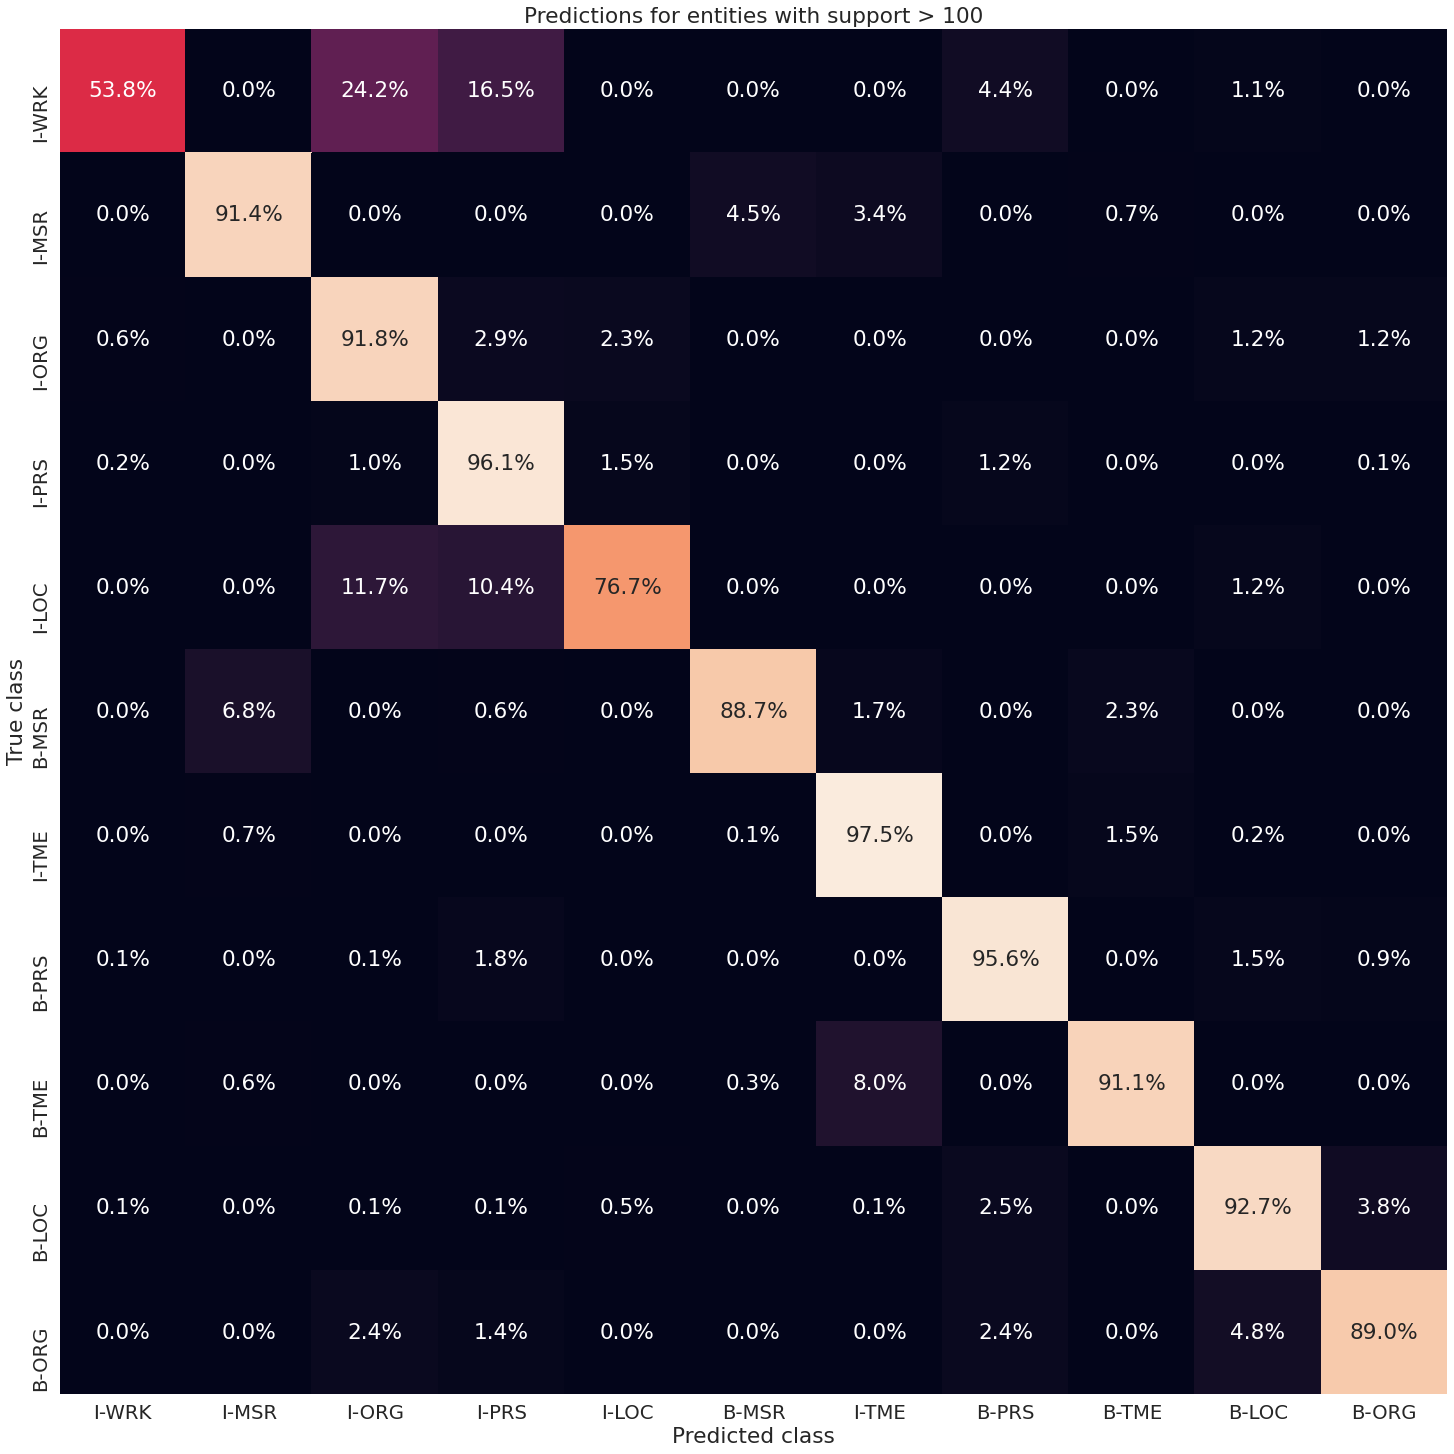

In [39]:
from sklearn.metrics import confusion_matrix
# The scikit confusion function also takes a list of labels. The generated confusion matrix will consist of the elements of this list, in the order they appear
cf_labels = support_labels

#Generate a confusion matrix
cmatrix = confusion_matrix(y_true=true_classes, y_pred=predicted_classes, labels = cf_labels)

#Use pandas for plotting purposes
cmatrix = pd.DataFrame(cmatrix, columns=cf_labels, index=cf_labels)

# The absolute number of things retrieved isn't as interesting as the relative retrival, so we normalize along the x-axis
cmatrix = cmatrix.apply(lambda x: x/x.sum(), axis = 1)

#Remove Nans
cmatrix = cmatrix.fillna(0)

#The confusion matrix is defined such that each row corresponds to a true label, each column is predicted label
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(cmatrix, ax = ax, annot=True, fmt=".1%", cbar=False)
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
plt.title("Predictions for entities with support > 100")
fig.tight_layout(pad=0)
plt.savefig("../data/assets/heatmap.png")
plt.show()

## Entity vs Non entity heatmap

For this I want to see how well the model distinguishes between entities and non-entities

Change the span of entities to be O and E


In [68]:
true_entities = []
for entity in true_classes:
    if entity == '[CLS]' or entity == '[SEP]' or entity == '<pad>':
        true_entities.append('S')
    elif entity == ['B-O'] or entity == ['B-I']:
        true_entities.append('Outside')
    else:
        true_entities.append('Named Entity')

In [69]:
predicted_entities = []
for entity in predicted_classes:
    if entity == '[CLS]' or entity == '[SEP]' or entity == '<pad>':
        predicted_entities.append('S')
    elif entity == ['B-O'] or entity == ['B-I']:
        predicted_entities.append('Outside')
    else:
        predicted_entities.append('Named Entity')

In [70]:
entity_labels = ['S', 'NE', 'O']
entity_labels = ['Named Entity', 'Outside']

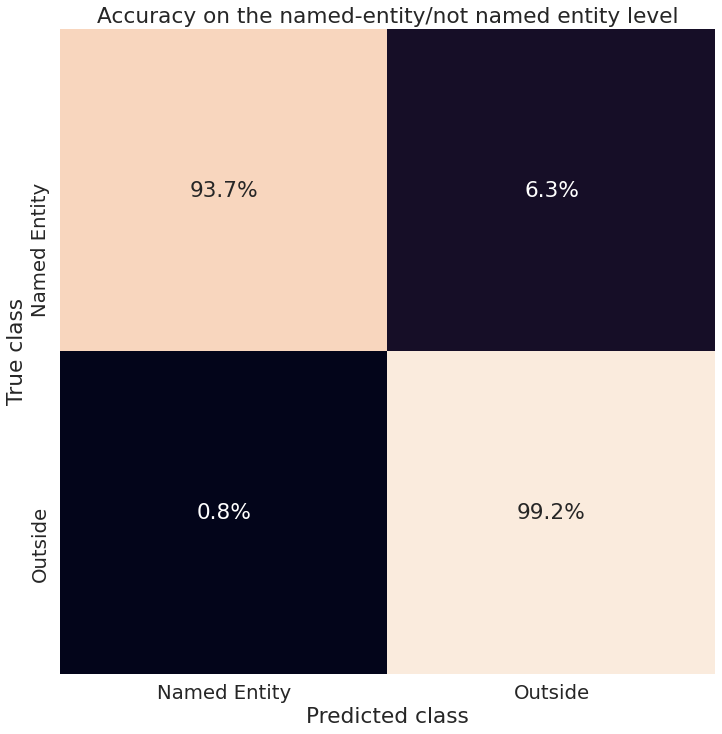

In [79]:
from sklearn.metrics import confusion_matrix
# The scikit confusion function also takes a list of labels. The generated confusion matrix will consist of the elements of this list, in the order they appear
cf_labels = support_labels

#Generate a confusion matrix
cmatrix = confusion_matrix(y_true=true_entities, y_pred=predicted_entities, labels=entity_labels)

#Use pandas for plotting purposes
cmatrix = pd.DataFrame(cmatrix, columns=entity_labels, index = entity_labels)

# The absolute number of things retrieved isn't as interesting as the relative retrival, so we normalize along the x-axis
cmatrix = cmatrix.apply(lambda x: x/x.sum(), axis = 1)

#Remove Nans
cmatrix = cmatrix.fillna(0)

#The confusion matrix is defined such that each row corresponds to a true label, each column is predicted label
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(cmatrix, ax = ax, annot=True, fmt=".1%", cbar=False)
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
plt.title("Accuracy on the named-entity/not named entity level")
fig.tight_layout(pad=0)
plt.savefig("../data/assets/NEO.png")
plt.show()

In [76]:
report6 = classification_report(y_true=true_entities, y_pred=predicted_entities, labels = entity_labels, output_dict=True, zero_division=0)
report6 = pd.DataFrame(report6).transpose()
report6

#save to file
caption = 'Classification report on the Named-Entity / Outside level'
label = 'l_NEO_report'
sentence_table = report6.to_latex(index=True, float_format="%.3f", caption=caption, label = label, bold_rows=True)
print(sentence_table)

\begin{table}
\centering
\caption{Classification report on the Named-Entity / Outside level}
\label{l_NEO_report}
\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &    support \\
\midrule
\textbf{Named Entity} &      0.976 &   0.936 &     0.955 &  37089.000 \\
\textbf{Outside     } &      0.978 &   0.992 &     0.985 & 106169.000 \\
\textbf{micro avg   } &      0.978 &   0.977 &     0.977 & 143258.000 \\
\textbf{macro avg   } &      0.977 &   0.964 &     0.970 & 143258.000 \\
\textbf{weighted avg} &      0.978 &   0.977 &     0.977 & 143258.000 \\
\bottomrule
\end{tabular}
\end{table}



# Others results

In [ ]:
comparison = pd.read_csv('../data/assets/comare.csv')

In [ ]:
#comparison.at[1, 'Classes'] = 4
#comparison.at[1, 'F1'] = 92.4

In [ ]:
comparison.to_csv('../data/assets/comare.csv', index = False)

In [ ]:
df = comparison[['Paper', 'F1']]
df = df.T
df.columns = df.loc['Paper']
df = df.loc[['F1']]
df

In [ ]:
df = comparison[['Paper', 'F1']]
df = df.T
df.columns = df.loc['Paper']
df = df.loc[['F1']]
df